#IDENTIFICATION OF ENT DISEASES THROUGH VOICE RECOGINATION.
mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



##Import libraries

In [ ]:
import os
import re
import glob
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
import tensorflow as tf
print(tf.__version__)
import librosa
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

#/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav

2.15.0


## DATA PREPROCESSING.
### Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) && Linear Predictive Cepstral Coefficients (LPCC) from the audio samples.

description of functions:
- def features_extractor_MFCC(file_name) : extract MFCC feature and normalize it(into 1-D arr of size 40) given a path of audio_file "file_name".
output: 1-D MFCC feature (size = 40 -> to change size change"n_mfcc" )
-features_extractor_lpcc: similar to MFCC return LPCC feature of size 24.
-features_extractor_currect_folder: This is a utility fxn to extract MFCC of  all audio file in current folder="folderpath"

In [ ]:
from sklearn.preprocessing import StandardScaler


def features_extractor_lpcc(file_name):
    audio, sample_rate = librosa.load(file_name)
    lpc_coefficients = librosa.lpc(audio, order=12)
    epsilon = 1e-10
    powerspectrum = np.abs(np.fft.fft(lpc_coefficients)) ** 2
    lpc_coefficients_offset = np.maximum(powerspectrum, epsilon)
    lpcc_features = np.fft.irfft(np.log(lpc_coefficients_offset))
    return lpcc_features

def features_extractor_MFCC(file_name):# extract mfcc normalise it
    audio, sample_rate = librosa.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

# iterate through all file in current folder ans call MFcc fxn return labeled feature {mfcc,label}
def features_extractor_currect_folder(foldername,label):
  label_feature=[]
  for filename in tqdm(glob.glob(foldername+'/*.wav')):
    data=features_extractor_MFCC(filename)
    data_lpcc=features_extractor_lpcc(filename)
    data = np.concatenate((data, data_lpcc), axis=0)
    label_feature.append([data,label])

  return label_feature




In [ ]:
data_lpcc=features_extractor_lpcc("/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie/1037-a_h.wav")
data_lpcc

array([ 0.75728234, -0.58179898, -1.51731968, -0.16540426, -0.42096893,
       -0.21073785, -0.34440479, -0.17862129, -0.30192544, -0.06836431,
       -0.22716163, -0.06079651, -0.21095387, -0.06079651, -0.22716163,
       -0.06836431, -0.30192544, -0.17862129, -0.34440479, -0.21073785,
       -0.42096893, -0.16540426, -1.51731968, -0.58179898])


## extrating feature and labeling dataset.
iterate through all folder one by one extracted mfcc for each file in that folder assig label based on folder name content keyword " healty -> 1" or " unhealthy -> 0".

example: Foldername
             -> folder_with_disease_name -> audio_file_name
<br>
so based on diseases name we label all file in folder with same label.


In [ ]:
folder_path='/content/drive/MyDrive/sbvoiceDataset/Dataset'
folders_labels=[[flder, 1 if 'healthy' in flder[len(folder_path):] else 0 ]for flder in glob.glob(folder_path+'/*')]

folder_path="/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/"
folders_labels2=[[flder, 1 if 'healthy' in flder[len(folder_path):] else 0 ]for flder in glob.glob(folder_path+'/*')]

label_features = []

for folder , label in (folders_labels):
  label_features.extend(features_extractor_currect_folder(folder,label))

for folder , label in (folders_labels2):
  label_features.extend(features_extractor_currect_folder(folder,label))

print(len(label_features))


100%|██████████| 448/448 [00:22<00:00, 19.49it/s]


5758


#### For Multiclass labeling precessing code.

In [ ]:
folder_path="/content/drive/MyDrive/sbvoiceDataset/Dataset/"
folders_labels = [
    (
        flder,
        0 if 'healthy' in flder[len(folder_path):] else
        1 if 'Dysphonie' in flder[len(folder_path):] else
        2 if 'laryngitis' in flder[len(folder_path):] else -1  # Default label if none match
    )
    for flder in glob.glob(folder_path + '/*')
]
print(folders_labels)

folder_path2="/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/"
folders_labels2= [
    (
        flder,
        0 if 'healthy' in flder[len(folder_path2):] else
        1 if 'Dysphonie' in flder[len(folder_path2):] else
        2 if 'laryngitis' in flder[len(folder_path2):] else -1  # Default label if none match
        ,

    )
    for flder in glob.glob(folder_path2 + '/*')
]
print(folders_labels2)

[('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/female_healthy', 0), ('/content/drive/MyDrive/sbvoiceDataset/Dataset/male_healthy', 0)]
[('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_Hyperfunktionelle_Dysphonie', 1), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_laryngitis', 2), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/female_healthy', 0), ('/content/drive/MyDrive/sbvoiceAUG_Dataset/AUG_Dataset/male_healthy', 0)]


In [ ]:
label_features = []

for folder , label in (folders_labels):
  label_features.extend(features_extractor_currect_folder(folder,label,len(folder_path2)))

for folder , label in (folders_labels2):
  label_features.extend(features_extractor_currect_folder(folder,label,len(folder_path2)))

print(len(label_features))


 70%|███████   | 315/448 [00:29<00:13, 10.16it/s]

### Save the processed data in JSON format

In [ ]:
label_features_df=pd.DataFrame(label_features,columns=['feature','class'])
print(label_features_df.tail())

processed_data_path_filename="/content/drive/MyDrive/sbvoiceDataset/"

#uncomment this to save then run cell..
label_features_df.to_json(processed_data_path_filename+'processed_data_filename_version.json')

                                                feature  class
5753  [-70.88627, 21.125088, 22.317429, 16.21537, 9....      1
5754  [-88.161285, 24.990473, 21.917425, 13.422932, ...      1
5755  [-186.6251, 55.567924, 46.357048, 31.229801, 1...      1
5756  [-64.05237, 31.217848, 14.517754, -3.2514853, ...      1
5757  [-221.32681, 85.340836, 53.363785, 24.329664, ...      1


### Load processed data for other processing if needed

In [ ]:
path="/content/drive/MyDrive/sbvoiceAUG_Dataset/"

label_features_df_saved=pd.read_json('/content/drive/MyDrive/sbvoiceAUG_Dataset/processed_data_multiclass_with_mfcc_lpcc.json')
# label_features_df_saved['class'] = label_features_df_saved['class'].apply(lambda x: 1 if x > 0 else x)
print(label_features_df_saved['class'].unique())

X=np.array(label_features_df_saved['feature'].tolist())
Y=np.array(label_features_df_saved['class'].tolist())
Y=Y.reshape((-1,1))

[1 2 0]


### SOME OTHER PROCESSING TECHNIQUE
+ PCA
+ DATA AUGUMENTATION.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # Standardize the data
# X is input feature .
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=0.99)  # Choose the number of components that explain 95% of the variance
X_train_pca = pca.fit_transform(X)

print(len(X[0]))

7
7


####DATA AUGMENTATION

used library audiomentaion for audio augmentation. both raw and spectogram transformation below cell contain fxn to augment file .

In [ ]:
!pip install audiomentations

In [ ]:
import librosa
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, SpecCompose, SpecChannelShuffle, SpecFrequencyMask


def audio_augmentation_wav(audio_file_path):
    # Load the audio data
    audio, sr = librosa.load(audio_file_path)

    # Create a Compose object with various audio transformations
    transform = Compose([
       AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.085,p=1),
       TimeStretch(min_rate=0.8, max_rate=1.15, p=0.8),
    ])

    # Apply the transformations to the audio data
    augmented_audio = transform(audio, sr)

    return augmented_audio,sr

#example :augmented_mfccs=audio_augmentation_spec(mfccs) extract mfcc without normalizing it (2-D array)

def audio_augmentation_spec(spec):
    # Create a Compose object with various spectrogram transformations
    transform = SpecCompose([
        SpecFrequencyMask(p=0.6),
    ])

    # Apply the transformations to the spectrogram
    augmented_spec = transform(spec)

    return augmented_spec


In [ ]:
# augment mfcss variable using audio_augmentation spec  and print spec before and after augmentation

import matplotlib.pyplot as plt
# filename: path of file to be augmented
audio, sample_rate = librosa.load(file_name)
mfccss = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
augmented_mfccs=audio_augmentation_spec(mfccs)

# Print the original and augmented MFCCs
print("Original MFCCs shape:", mfccs.shape)
print("Augmented MFCCs shape:", augmented_mfccs.shape)

# Plot the original and augmented MFCCs
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
librosa.display.specshow(mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Original MFCCs')
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(augmented_mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Augmented MFCCs')
plt.colorbar()
plt.show()


In [ ]:
#plot that difference of mfccs and augmented_mfccs

import matplotlib.pyplot as plt

# Calculate the difference between the original and augmented MFCCs
diff_mfccs = mfccs - augmented_mfccs

# Plot the difference
plt.figure(figsize=(10, 5))
librosa.display.specshow(diff_mfccs, x_axis='time', y_axis='mel', sr=librosa_sample_rate)
plt.title('Difference between Original and Augmented MFCCs')
plt.colorbar()
plt.show()


In [ ]:
## HERE we want to Augment data only once so in this cell we can write code for extracting
## files one by one augment it and save file if raw in some other folder then orginal
## data or then apply spec transformation on saved augmented data and then save the processed data in JSON.

###TRAING MODEL..
 DEFINE MODEL ARCHITECTURE ( NO OF LAYERS.. OPTMIZER,LOSS FXN, ACTIVATION FXN ETC )

Split the data

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=0)

print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)


(4606, 64) (1152, 64)
(4606, 1) (1152, 1)


In [ ]:

def create_model(input_size):
    model=Sequential()
    ###first layer
    model.add(Dense(100,input_shape=(input_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###4th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    learning_rate = 0.0005  # Adjust the learning rate as needed
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer=optimizer)

    return model


## ANN MODEL..

#### ANN MODEL ARCHTECTURE..

In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def create_model_ann(input_size):
    model=Sequential()
    ###first layer
    model.add(Dense(300,input_shape=(input_size,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###4th layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###5th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(3))
    model.add(Activation('softmax'))

    learning_rate = 0.00075  # Adjust the learning rate as needed
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)
    return model
# # Load the saved model
# loaded_model = load_model(model_path)
# test_accuracy=loaded_model.evaluate(X_test,Y_test,verbose=0)
# print(test_accuracy[1])
# estimator = KerasClassifier(build_fn=create_model, epochs=500, batch_size=150, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
# results = cross_val_score(estimator, X, Y, cv=kfold,scoring='accuracy')

####CROSS - VALIDATION SCORE..
calculate for cross validation score before start trainng for designed architecture..

In [ ]:
!pip install scikeras

In [ ]:


from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=256, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
results = cross_val_score(estimator, X_train, Y_train, cv=kfold,scoring='accuracy')

In [ ]:
results.mean()

0.7262286819240615

#### START TRAINING
it will save parameter with higher accuracy automatically if achived while training..(change path while exprimenting not to overwrite parametera saved)..

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

# model=create_model_ann(len(X_train_pca[0]))
model = create_model(len(X_train_pca[0]))
print(model.summary())
# model.compile(loss='BinaryCrossentropy',metrics=['accuracy'],optimizer='adam')

num_epochs = 400
num_batch_size = 64

checkpointer = ModelCheckpoint(filepath=path+'/saved_models/dieases_classification_lpcc_pca.hdf5',
                               monitor='val_accuracy',  # Monitor validation accuracy
                               verbose=1,
                               save_best_only=True,  # Save only the best model
                               mode='max')

start = datetime.now()

model.fit(X_train_pca, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_pca, Y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

### LOAD THE SAVED MODEL..print result such as accuracy,F1-score along with Confusion matrix for then saved model.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model(path+'/saved_models/dieases_classification_lpcc_pca.hdf5')

# Predict the results
Y_pred = loaded_model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, f1-score, and accuracy
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1_score = f1_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Accuracy:", accuracy)

In [ ]:
#training ANN model...
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

model=create_model_ann()

num_epochs = 500
num_batch_size =128

checkpointer = ModelCheckpoint(filepath=path+'/saved_models/ANN_model_on_aug_dataset_7th_layer.hdf5',
                               verbose=1)
start = datetime.now()

model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

# BELOW - ALL - CELL are DUMPED CODE...

36/36 [==============================] - 0s 3ms/step


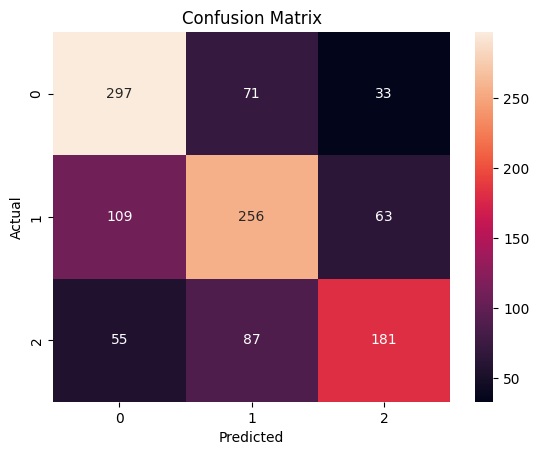

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model(path+'/saved_models/ANN_model_on_aug_dataset_7th_layer.hdf5')

# Predict the results
Y_pred = loaded_model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# # from tensorflow.keras.models import load_model
# # model_path = path + '/saved_models/dieases_classification.hdf5'
# from scikeras.wrappers import KerasRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

def create_model_ann_pca():
    model=Sequential()
    ###first layer
    model.add(Dense(300,input_shape=(32,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###4th layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###5th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(3))
    model.add(Activation('softmax'))

    learning_rate = 0.0005  # Adjust the learning rate as needed
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)
    return model
# # Load the saved model
# loaded_model = load_model(model_path)
# test_accuracy=loaded_model.evaluate(X_test,Y_test,verbose=0)
# print(test_accuracy[1])
# estimator = KerasClassifier(build_fn=create_model, epochs=500, batch_size=150, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
# results = cross_val_score(estimator, X, Y, cv=kfold,scoring='accuracy')

In [ ]:
#training ANN model...
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

model=create_model_ann_pca()

num_epochs = 400
num_batch_size =64

checkpointer = ModelCheckpoint(filepath=path+'/saved_models/ANN_model_mfcc_plus_lpcc_pca.hdf5',
                               monitor='val_accuracy',  # Monitor validation accuracy
                               verbose=1,
                               save_best_only=True,  # Save only the best model
                               mode='max')
start = datetime.now()

model.fit(X_train_pca, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_pca, Y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

36/36 [==============================] - 0s 4ms/step


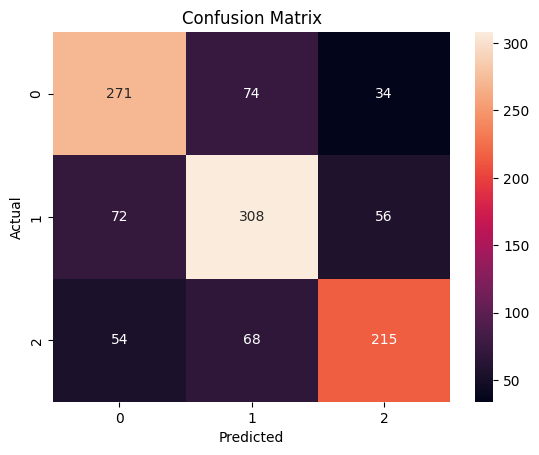

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model(path+'/saved_models/ANN_model_mfcc_plus_lpcc_pca.hdf5')

# Predict the results
Y_pred = loaded_model.predict(X_test_pca)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
f1_scr = f1_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_scr)
print("Accuracy:", accuracy)

Precision: 0.6906607081954977
Recall: 0.6864812640102443
F1 Score: 0.6878317111303517
Accuracy: 0.6892361111111112


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model(path+'/saved_models/ANN_model_on_aug_dataset_7th_layer_pca.hdf5')

# Predict the results
Y_pred = loaded_model.predict(X_test_pca)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# prompt: now calculate precison, recall, for the same,accuracy

from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, and accuracy
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# # # # Standardize the data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print(len(X_train_scaled[0]))
# # Perform PCA
# pca = PCA(n_components=0.97)  # Choose the number of components that explain 95% of the variance
# X_train_lm = pca.fit_transform(X_train_scaled)
# X_test_lm = pca.transform(X_test_scaled)

# print(len(X_train_lm[0]))
# print(len(X_test_lm[0]))


64
32
32


In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# # from tensorflow.keras.models import load_model
# # model_path = path + '/saved_models/dieases_classification.hdf5'
# from scikeras.wrappers import KerasRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

def create_model_ann_lpcc():
    model=Sequential()
    ###first layer
    model.add(Dense(300,input_shape=(6,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###4th layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###5th layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###6th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(3))
    model.add(Activation('softmax'))

    learning_rate = 0.00045  # Adjust the learning rate as needed
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)
    return model
# # Load the saved model
# loaded_model = load_model(model_path)
# test_accuracy=loaded_model.evaluate(X_test,Y_test,verbose=0)
# print(test_accuracy[1])
# estimator = KerasClassifier(build_fn=create_model, epochs=500, batch_size=150, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
# results = cross_val_score(estimator, X, Y, cv=kfold,scoring='accuracy')

In [ ]:
#training ANN model...
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

model=create_model_ann_lpcc()

num_epochs = 400
num_batch_size =64

checkpointer = ModelCheckpoint(filepath=path+'/saved_models/ANN_model_on_aug_dataset_7th_layer_lpcc.hdf5',
                               verbose=1)
start = datetime.now()

model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, Y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model(path+'/saved_models/ANN_model_on_aug_dataset_7th_layer_lpcc.hdf5')

# Predict the results
Y_pred = loaded_model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# prompt: now calculate precison, recall, for the same,accuracy

from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, and accuracy
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


In [ ]:
path="/content/drive/MyDrive/sbvoiceDataset/"
label_features_df_saved=pd.read_json('/content/drive/MyDrive/sbvoiceAUG_Dataset/processed_data_multiclass_with_gender_age.json')
label_features_df_saved.tail()

X_lpcc=np.array(label_features_df_saved['feature'].tolist())
Y_lpcc=np.array(label_features_df_saved['class'].tolist())
Y_lpcc=Y_lpcc.reshape((-1,1))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # Standardize the data
scaler = StandardScaler()
X_lpcc_scaled = scaler.fit_transform(X_lpcc)
# X_test_scaled = scaler.transform(X_test)

print(len(X_lpcc_scaled[0]))
# # Perform PCA
pca = PCA(n_components=0.988)  # Choose the number of components that explain 98.8% of the variance
X_lm = pca.fit_transform(X_lpcc_scaled)
# X_test_lm = pca.transform(X_test_scaled)

print(len(X_lm[0]))

41
36


In [ ]:
# implementing train-test-split
X_train, X_test, Y_train, Y_test = train_test_split(X_lm, Y_lpcc, test_size=0.2, random_state=60)
# Y_train, Y_test = to_categorical(Y_train), to_categorical(Y_test)
print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)



(4606, 6) (1152, 6)
(4606, 1) (1152, 1)


In [ ]:
# from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
# # from tensorflow.keras.models import load_model
# # model_path = path + '/saved_models/dieases_classification.hdf5'
# from scikeras.wrappers import KerasRegressor
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

def create_model_ann_lpcc_mfccs():
    model=Sequential()
    ###first layer
    model.add(Dense(300,input_shape=(38,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###second layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###third layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###4th layer
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###5th layer
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    ###6th layer
    model.add(Dense(32))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    ###final layer
    model.add(Dense(3))
    model.add(Activation('softmax'))

    learning_rate = 0.00045  # Adjust the learning rate as needed
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)
    return model
# # Load the saved model
# loaded_model = load_model(model_path)
# test_accuracy=loaded_model.evaluate(X_test,Y_test,verbose=0)
# print(test_accuracy[1])
# estimator = KerasClassifier(build_fn=create_model, epochs=500, batch_size=150, verbose=0)
# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Adjust the number of splits as needed
# results = cross_val_score(estimator, X, Y, cv=kfold,scoring='accuracy')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

model = create_model_ann_lpcc()

num_epochs = 400
num_batch_size = 64

# Define the filepath for saving the best model
checkpoint_path = path + '/saved_models/ANN_model_on_aug_dataset_7th_layer_lpcc_mfcc.hdf5'

# Define ModelCheckpoint callback with save_best_only=True
checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                               monitor='val_accuracy',  # Monitor validation accuracy
                               verbose=1,
                               save_best_only=True,  # Save only the best model
                               mode='max')  # Save when validation accuracy is maximized

start = datetime.now()

# Train the model with ModelCheckpoint callback
model.fit(X_train, Y_train,
          batch_size=num_batch_size,
          epochs=num_epochs,
          validation_data=(X_test, Y_test),
          callbacks=[checkpointer],
          verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Load the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/sbvoiceDataset//saved_models/ANN_model_on_aug_dataset_7th_layer_lpcc_mfcc.hdf5")

# Predict the results
Y_pred = loaded_model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# prompt: now calculate precison, recall, for the same,accuracy

from sklearn.metrics import precision_score, recall_score, accuracy_score
# Calculate precision, recall, and accuracy
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')
accuracy = accuracy_score(Y_test, Y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


---- scrap code--------

In [ ]:
label_features=[]
folder_path='/content/drive/MyDrive/sbvoiceDataset/Dataset'
folders_labels=[[flder, 1 if 'healthy' in flder[len(folder_path):] else 0 ]for flder in glob.glob(folder_path+'/*')]

for folder , label in (folders_labels):
  label_features.extend(features_extractor_currect_folder(folder,label))